In [1]:
import sys
print(sys.version)


2.7.12 |Anaconda 4.2.0 (64-bit)| (default, Jun 29 2016, 11:07:13) [MSC v.1500 64 bit (AMD64)]


In [18]:
%matplotlib inline
# import necessary libraries and specify that graphs should be plotted inline.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets, preprocessing, tree, model_selection,svm
from sklearn.feature_selection import SelectFromModel,RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR, LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict, StratifiedKFold
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, roc_curve, auc
from scipy import interp
from ggplot import *

In [2]:
spam_data = pd.read_csv("C:/Users/venka/Documents/Fall Semester/Predictive Analytics/Assignment 4/spambasedata.csv",header=None)
spam_data=spam_data.as_matrix()

predictors=spam_data[:,:57]
target=spam_data[:,57]

min_max_scaler = preprocessing.MinMaxScaler()
predictors_norm = min_max_scaler.fit_transform(predictors)



In [164]:
# pre processing
# model=SVR(kernel="linear")
# model=LogisticRegression()
# selector = RFECV(model, step=1, cv=5)
# fitted = selector.fit(predictors, target)
# predictors_model = SelectFromModel(selector, prefit=True)
# predictors_new=predictors_model.transform(predictors)

lsvc = LinearSVC(C=0.01, penalty="l2", dual=False).fit(predictors_norm, target)
model = SelectFromModel(lsvc, prefit=True)
predictors_new_v1 = model.transform(predictors_norm)

# print predictors_new.shape
# print predictors_new[:5,:]
# clf = Pipeline([
#   ('feature_selection', SelectFromModel(LinearSVC(penalty="l2"))),
#   ('classification', RandomForestClassifier())
# ])
# clf.fit(X, y)
print 'The model is {}'.format(model)


The model is SelectFromModel(estimator=LinearSVC(C=0.01, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
        prefit=True, threshold=None)


In [149]:
clf = ExtraTreesClassifier()
clf = clf.fit(predictors_norm, target)
clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
predictors_new = model.transform(predictors_norm)
print predictors_new.shape

(4601L, 21L)


In [5]:
cost_matrix=np.matrix([[0, 10], [1, 0]])

In [93]:
#k-NN (Feature selection - Linear SVC)
k_best=0
accuracy_previous_knn=0
min_k=3
max_k=53
step=2
accuracy_knn_all = []
neighbors_range=range(min_k,max_k,step)

for n_neighbors in neighbors_range:
    knn = neighbors.KNeighborsClassifier(n_neighbors,weights='distance',metric='manhattan')
    predicted_knn = cross_val_predict (knn, predictors_new, target, cv=10)
    accuracy_knn=metrics.accuracy_score(target, predicted_knn)*100
    accuracy_knn_all.append(accuracy_knn)
    
    if accuracy_knn>accuracy_previous_knn:
        precision_knn = metrics.precision_score(target,predicted_knn)
        recall_knn = metrics.recall_score(target,predicted_knn)
        f_knn= metrics.f1_score(target,predicted_knn)
        cm_knn=confusion_matrix(target,predicted_knn)
        profit_matrix_knn = np.multiply(cm_knn, cost_matrix)
        miscal_cost_knn = profit_matrix_knn.item(1) + profit_matrix_knn.item(2)
        k_best=n_neighbors
        accuracy_previous_knn=accuracy_knn
        

knn_best = neighbors.KNeighborsClassifier(k_best,weights='distance',metric='manhattan')
pred_prob_knn= cross_val_predict (knn_best, predictors_new, target, cv=10, method='predict_proba')
auc_knn= metrics.roc_auc_score(target,pred_prob_knn[:,1])
print 'The best K-value: {}'.format(k_best)
print 'Accuracy: {:.2f}%' .format(accuracy_previous_knn)
print 'Precision: {:.2f}%'.format(precision_knn*100)
print 'Recall: {:.2f}%'.format(recall_knn*100)
print 'F measure: {:.2f}'.format(f_knn)
print 'AUC: {:.2f}'.format(auc_knn)
print 'Misclassification cost: ${}' .format(miscal_cost_knn)
print 'The confusion matrix is \n{}'.format(cm_knn)

The best K-value: 19
Accuracy: 90.70%
Precision: 94.36%
Recall: 81.25%
F measure: 0.87
AUC: 0.96
Misclassification cost: $1220
The confusion matrix is 
[[2700   88]
 [ 340 1473]]


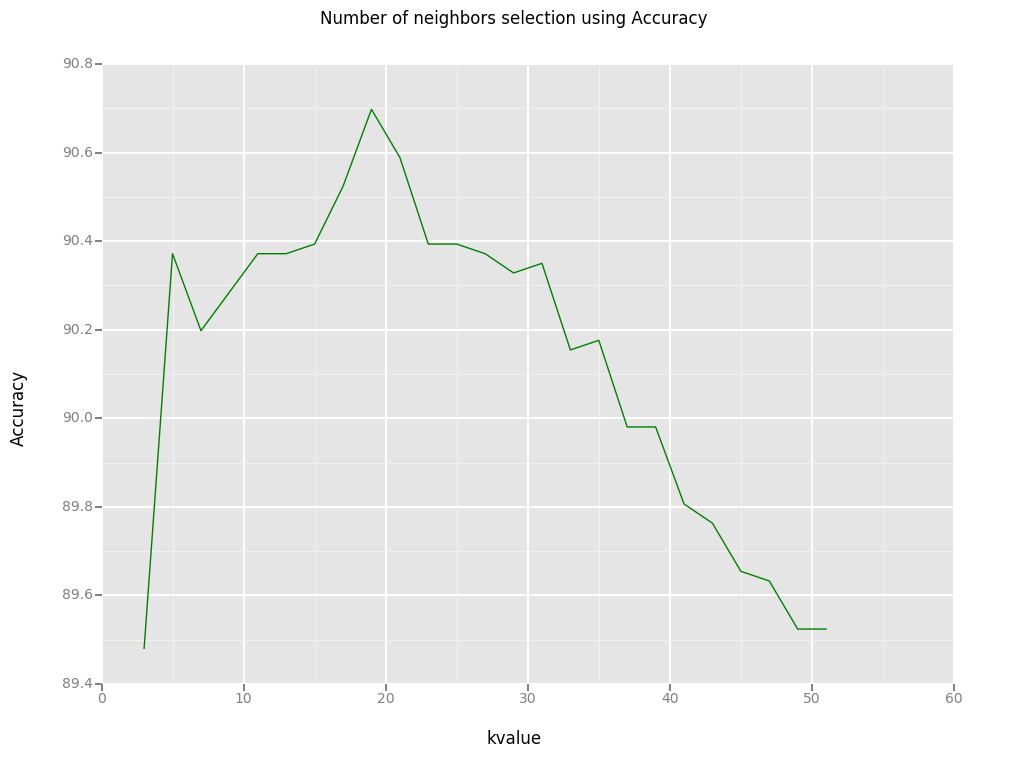

<ggplot: (22876255)>

In [92]:
accuracy_knn_df=pd.DataFrame(accuracy_knn_all)
accuracy_knn_df.columns=['Accuracy']
accuracy_knn_df['kvalue']=neighbors_range
ggplot(accuracy_knn_df, aes(x='kvalue',y='Accuracy')) + geom_line(color='green') +ggtitle('Number of neighbors selection using Accuracy')

# plt.plot(accuracy_knn_df)
# plt.xlabel("k value")
# plt.ylabel("Accuracy")
# plt.title('Number of neighbors selection using Accuracy')
# plt.show()

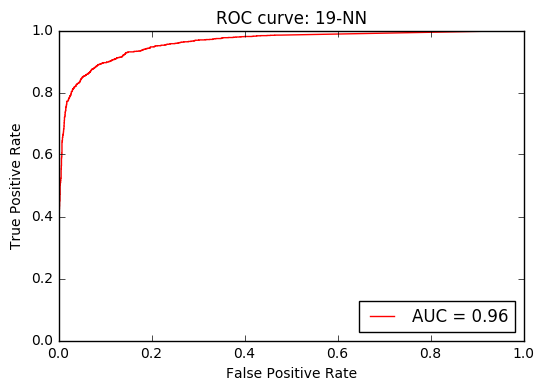

In [97]:
#ROC curve (For selected k)
fpr, tpr, thresholds = roc_curve(target, pred_prob_knn[:, 1])
plt.plot(fpr, tpr, lw=1, color='r',label='AUC = %0.2f' % (auc_knn))
plt.xlim([0.0, 1.00])
plt.ylim([0.0, 1.00])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: {}-NN'.format(k_best))
plt.legend(loc="lower right")
plt.show()

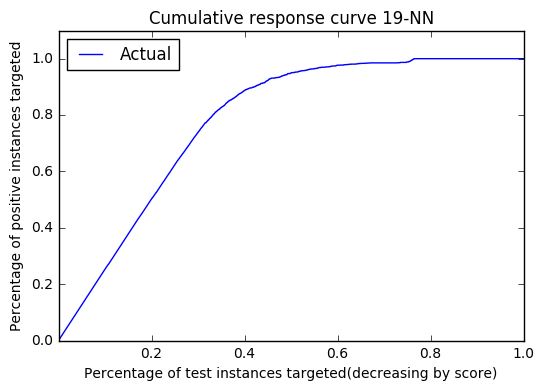

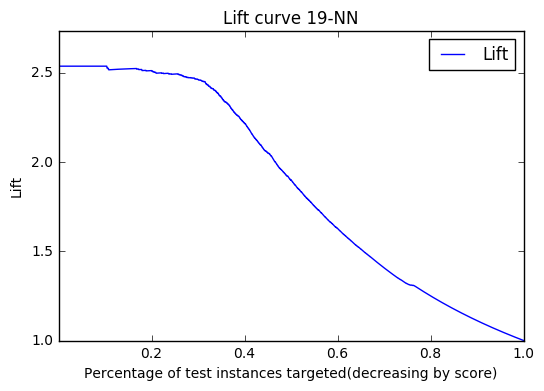

In [112]:
#CR curve and Lift curve
target_bc=pd.get_dummies(target).as_matrix()
ppd_pd=pd.DataFrame(pred_prob_knn[:,1],columns=['Predicted_prob'])
ppd_pd['Actual']=pd.Series(target_bc[:,1])
ppd_pd_sorted=ppd_pd.sort_values(['Predicted_prob'],ascending=0)
ppd_pd_sorted.index=range(1,len(ppd_pd_sorted.index)+1)

percent_targeted = pd.DataFrame(ppd_pd_sorted['Actual'].cumsum()/ppd_pd_sorted['Actual'].sum())
percent_targeted['Percent_test_instances']=range(1,len(ppd_pd_sorted.index)+1)
percent_targeted['Percent_test_instances']=percent_targeted['Percent_test_instances']/len(ppd_pd_sorted.index)
percent_targeted.index=range(1,len(ppd_pd_sorted.index)+1)
percent_targeted.plot(x='Percent_test_instances',y='Actual',ylim=[0,percent_targeted['Actual'].max()+0.1])
plt.xlabel('Percentage of test instances targeted(decreasing by score)')
plt.ylabel('Percentage of positive instances targeted')
plt.title('Cumulative response curve {}-NN'.format(k_best))

percent_targeted['Actual_targetted']=ppd_pd_sorted['Actual']
percent_targeted['Lift']=percent_targeted['Actual_targetted'].cumsum()/(percent_targeted['Actual_targetted'].sum()*percent_targeted.index*1.0000/4601)
percent_targeted.plot(x='Percent_test_instances',y='Lift',ylim=[1,percent_targeted['Lift'].max()+0.2])
plt.xlabel('Percentage of test instances targeted(decreasing by score)')
plt.ylabel('Lift')
plt.title('Lift curve {}-NN'.format(k_best))

In [178]:
#Decision tree
complexity_values = range(1,15)
accuracy_previous_dtree=0
accuracy_dtree_all = []
depth_best=0

for complexity_value in complexity_values:
    dtree = tree.DecisionTreeClassifier(criterion="entropy", max_depth=complexity_value,class_weight='balanced' )
    predicted_dtree = cross_val_predict (dtree, predictors_new, target, cv=10)
    
    cm_dtree=confusion_matrix(target,predicted_dtree)
    accuracy_dtree=metrics.accuracy_score(target, predicted_dtree)*100
    accuracy_dtree_all.append(accuracy_dtree)
        
    if accuracy_dtree>accuracy_previous_dtree:
        profit_matrix_dtree = np.multiply(cm_dtree, cost_matrix)
        miscal_cost_dtree = profit_matrix_dtree.item(1) + profit_matrix_dtree.item(2)
        precision_dtree = metrics.precision_score(target,predicted_dtree)
        recall_dtree = metrics.recall_score(target,predicted_dtree)
        f_dtree= metrics.f1_score(target,predicted_dtree)
        accuracy_previous_dtree=accuracy_dtree
        depth_best=complexity_value
        cmbest=cm_dtree
        
dtree_best = tree.DecisionTreeClassifier(criterion="entropy", max_depth=depth_best)
pred_prob_dtree= cross_val_predict (dtree_best, predictors_new, target, cv=10, method='predict_proba')
auc_dtree= metrics.roc_auc_score(target,pred_prob_dtree[:,1])

In [179]:
print 'The optimal depth: {}'.format(depth_best)
print 'Accuracy: {:.2f}%' .format(accuracy_previous_dtree)
print 'Precision: {:.2f}%'.format(precision_dtree*100)
print 'Recall: {:.2f}%'.format(recall_dtree*100)
print 'F measure: {:.2f}'.format(f_dtree)
print 'AUC: {:.2f}'.format(auc_dtree)
print 'Misclassification cost: ${}\n' .format(miscal_cost_dtree)
print 'The confusion matrix is \n{}'.format(cmbest)

The optimal depth: 9
Accuracy: 91.26%
Precision: 90.15%
Recall: 87.37%
F measure: 0.89
AUC: 0.94
Misclassification cost: $1959

The confusion matrix is 
[[2615  173]
 [ 229 1584]]


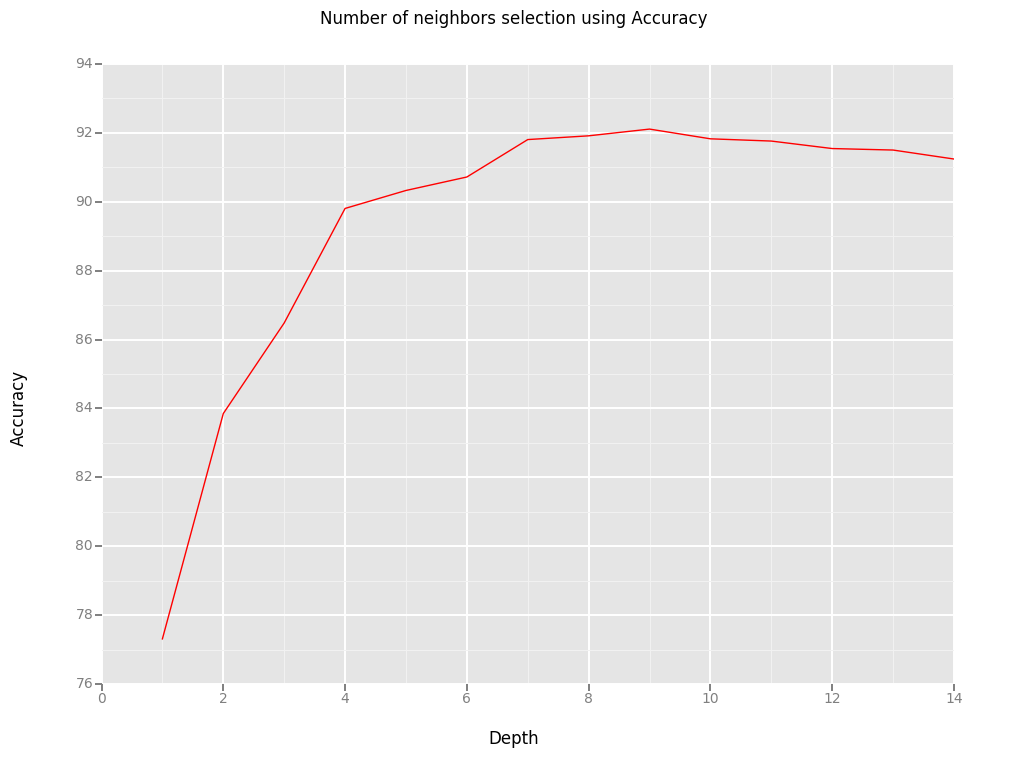

<ggplot: (21268028)>

In [130]:
accuracy_dtree_df=pd.DataFrame(accuracy_dtree_all)
accuracy_dtree_df.columns=['Accuracy']
accuracy_dtree_df['Depth']=complexity_values
ggplot(accuracy_dtree_df, aes(x='Depth',y='Accuracy')) + geom_line(color='red') +ggtitle('Number of neighbors selection using Accuracy')



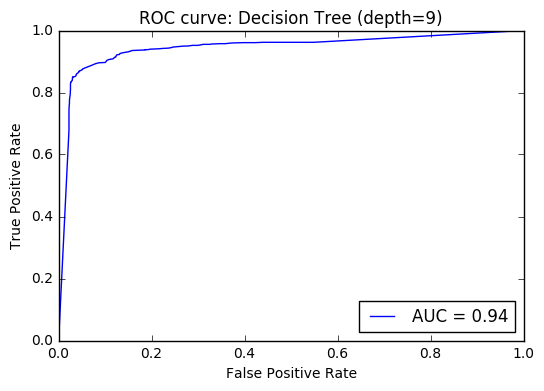

In [132]:
#ROC curve (Decision tree)
fpr, tpr, thresholds = roc_curve(target, pred_prob_dtree[:, 1])
plt.plot(fpr, tpr, lw=1, label='AUC = %0.2f' % (auc_dtree))
plt.xlim([0.0, 1.00])
plt.ylim([0.0, 1.00])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: Decision Tree (depth={})'.format(depth_best))
plt.legend(loc="lower right")
plt.show()

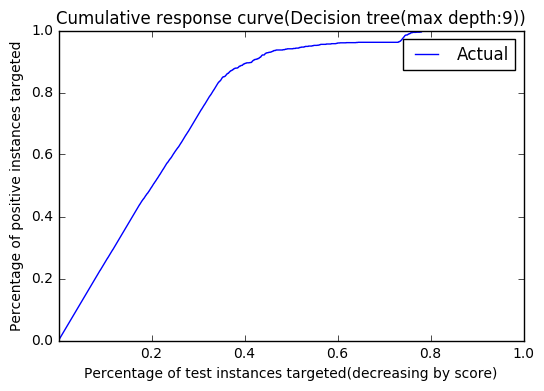

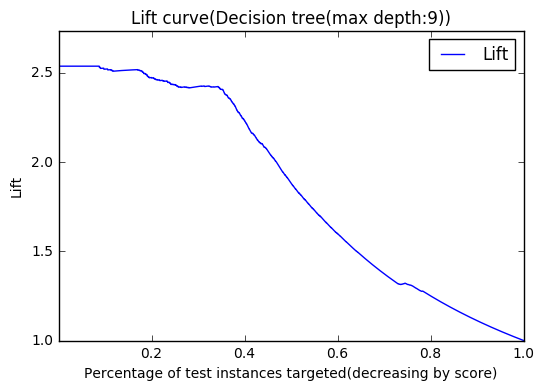

In [133]:
#CR curve and Lift curve
target_bc=pd.get_dummies(target).as_matrix()
ppd_pd=pd.DataFrame(pred_prob_dtree[:,1],columns=['Predicted_prob'])
ppd_pd['Actual']=pd.Series(target_bc[:,1])
ppd_pd_sorted=ppd_pd.sort_values(['Predicted_prob'],ascending=0)
ppd_pd_sorted.index=range(1,len(ppd_pd_sorted.index)+1)

percent_targeted = pd.DataFrame(ppd_pd_sorted['Actual'].cumsum()/ppd_pd_sorted['Actual'].sum())
percent_targeted['Percent_test_instances']=range(1,len(ppd_pd_sorted.index)+1)
percent_targeted['Percent_test_instances']=percent_targeted['Percent_test_instances']/len(ppd_pd_sorted.index)
percent_targeted.index=range(1,len(ppd_pd_sorted.index)+1)
percent_targeted.plot(x='Percent_test_instances',y='Actual')
plt.xlabel('Percentage of test instances targeted(decreasing by score)')
plt.ylabel('Percentage of positive instances targeted')
plt.title('Cumulative response curve(Decision tree(max depth:{}))'.format(depth_best))

percent_targeted['Actual_targetted']=ppd_pd_sorted['Actual']
percent_targeted['Lift']=percent_targeted['Actual_targetted'].cumsum()/(percent_targeted['Actual_targetted'].sum()*percent_targeted.index*1.0000/4601)
percent_targeted.plot(x='Percent_test_instances',y='Lift',ylim=[1,percent_targeted['Lift'].max()+0.2])
plt.xlabel('Percentage of test instances targeted(decreasing by score)')
plt.ylabel('Lift')
plt.title('Lift curve(Decision tree(max depth:{}))'.format(depth_best))

In [152]:
lr = LogisticRegression(C=1e5)
predicted_lr = cross_val_predict (lr, predictors_new, target, cv=10)
    
pred_prob_lr= cross_val_predict (lr, predictors_new, target, cv=10, method='predict_proba')
cm_lr=confusion_matrix(target,predicted_lr)
profit_matrix_lr = np.multiply(cm_lr, cost_matrix)
miscal_cost_lr = profit_matrix_lr.item(1) + profit_matrix_lr.item(2)
precision_lr = metrics.precision_score(target,predicted_lr)
recall_lr = metrics.recall_score(target,predicted_lr)
f_lr= metrics.f1_score(target,predicted_lr)
auc_lr= metrics.roc_auc_score(target,pred_prob_lr[:,1])
    
print 'Accuracy: {:.2f}%' .format(metrics.accuracy_score(target, predicted_lr)*100)
print 'Precision: {:.2f}%'.format(precision_lr*100)
print 'Recall: {:.2f}%'.format(recall_lr*100)
print 'F measure: {:.2f}'.format(f_lr)
print 'AUC: {:.2f}'.format(auc_lr)
print 'Misclassification cost: ${}' .format(miscal_cost_lr) 
print 'The confusion matrix is \n{}'.format(cm_lr)

Accuracy: 90.92%
Precision: 90.81%
Recall: 85.60%
F measure: 0.88
AUC: 0.96
Misclassification cost: $1831
The confusion matrix is 
[[2631  157]
 [ 261 1552]]


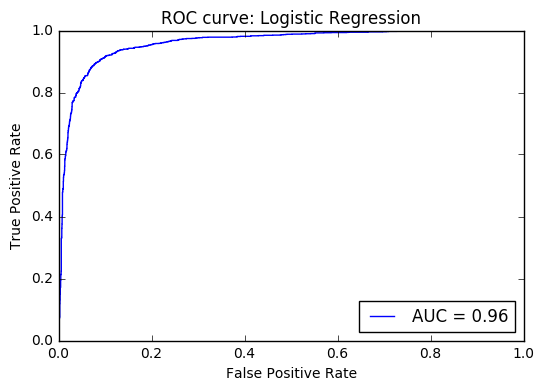

In [143]:
#ROC curve
fpr, tpr, thresholds = roc_curve(target, pred_prob_lr[:, 1])
plt.plot(fpr, tpr, lw=1, label='AUC = %0.2f' % (auc_lr))
plt.xlim([0.0, 1.00])
plt.ylim([0.0, 1.00])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: Logistic Regression')
plt.legend(loc="lower right")
plt.show()

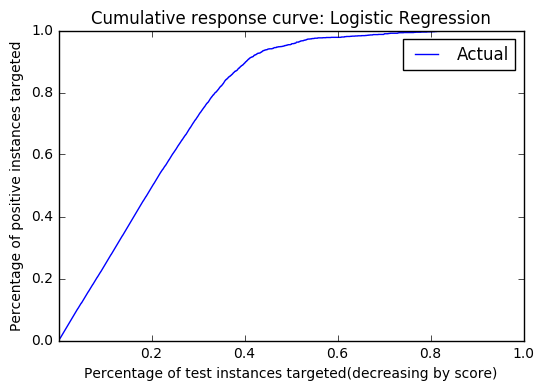

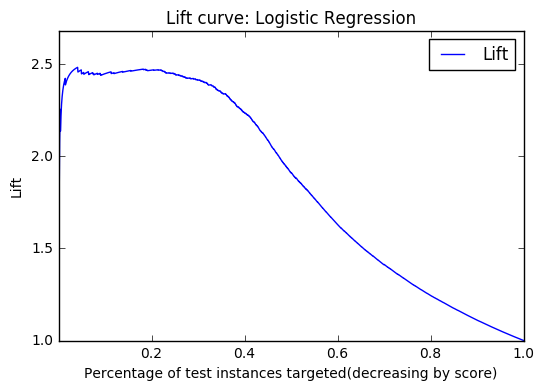

In [153]:
#CR curve and Lift curve
target_bc=pd.get_dummies(target).as_matrix()
ppd_pd=pd.DataFrame(pred_prob_lr[:,1],columns=['Predicted_prob'])
ppd_pd['Actual']=pd.Series(target_bc[:,1])
ppd_pd_sorted=ppd_pd.sort_values(['Predicted_prob'],ascending=0)
ppd_pd_sorted.index=range(1,len(ppd_pd_sorted.index)+1)

percent_targeted = pd.DataFrame(ppd_pd_sorted['Actual'].cumsum()/ppd_pd_sorted['Actual'].sum())
percent_targeted['Percent_test_instances']=range(1,len(ppd_pd_sorted.index)+1)
percent_targeted['Percent_test_instances']=percent_targeted['Percent_test_instances']/len(ppd_pd_sorted.index)
percent_targeted.index=range(1,len(ppd_pd_sorted.index)+1)
percent_targeted.plot(x='Percent_test_instances',y='Actual')
plt.xlabel('Percentage of test instances targeted(decreasing by score)')
plt.ylabel('Percentage of positive instances targeted')
plt.title('Cumulative response curve: Logistic Regression')

percent_targeted['Actual_targetted']=ppd_pd_sorted['Actual']
percent_targeted['Lift']=percent_targeted['Actual_targetted'].cumsum()/(percent_targeted['Actual_targetted'].sum()*percent_targeted.index*1.0000/4601)
percent_targeted.plot(x='Percent_test_instances',y='Lift',ylim=[1,percent_targeted['Lift'].max()+0.2])
plt.xlabel('Percentage of test instances targeted(decreasing by score)')
plt.ylabel('Lift')
plt.title('Lift curve: Logistic Regression')

In [169]:
accuracy_previous_svc=0
count=0
kernels=['linear', 'rbf', 'sigmoid']
accuracy_svc_all = []

In [180]:
for kernel in kernels:
    svc = SVC(C=10.0, kernel=kernel,degree=3,max_iter=5)
    predicted_svc = cross_val_predict(svc, predictors_new_v1, target, cv=10)
    cm_svc=confusion_matrix(target,predicted_svc)
    accuracy_svc=metrics.accuracy_score(target, predicted_svc)*100
    accuracy_svc_all.append(accuracy_svc)
     
    if accuracy_svc>accuracy_previous_svc:
        profit_matrix_svc = np.multiply(cm_svc, cost_matrix)
        miscal_cost_svc = profit_matrix_svc.item(1) + profit_matrix_svc.item(2)
        precision_svc = metrics.precision_score(target,predicted_svc)
        recall_svc = metrics.recall_score(target,predicted_svc)
        f_svc = metrics.f1_score(target,predicted_svc)
        accuracy_previous_svc=accuracy_svc
        kernel_best=kernel
        cm_best_svc=cm_svc

svc_prob = SVC(C=0.1, probability=True,kernel=kernel_best)
pred_prob_svc = cross_val_predict(svc_prob, predictors_new_v1, target, cv=10, method='predict_proba')
auc_svc = metrics.roc_auc_score(target,pred_prob_svc[:,1])

C:\Users\venka\Anaconda2\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [181]:
print 'Accuracy: {:.2f}%' .format(accuracy_previous_svc)
print 'Precision: {:.2f}%'.format(precision_svc*100)
print 'Recall: {:.2f}%'.format(recall_svc*100)
print 'F measure: {:.2f}'.format(f_svc)
print 'AUC: {:.2f}'.format(auc_svc)
print 'Misclassification cost: ${}' .format(miscal_cost_svc) 
print 'The best kernel for SVC is {}' .format(kernel_best)
print 'The confusion matrix is \n{}'.format(cm_best_svc)

# miscal_svc_df=pd.DataFrame(miscal_svc)
# miscal_svc_df.index=kernels
# plt.plot(miscal_svc_df)
# plt.xlabel("Kernel")
# plt.ylabel("Misclassification cost")
# plt.title('Kernel selection using miscalssification cost')
# plt.show()

Accuracy: 91.05%
Precision: 90.56%
Recall: 86.27%
F measure: 0.88
AUC: 0.92
Misclassification cost: $1879
The best kernel for SVC is linear
The confusion matrix is 
[[2625  163]
 [ 249 1564]]


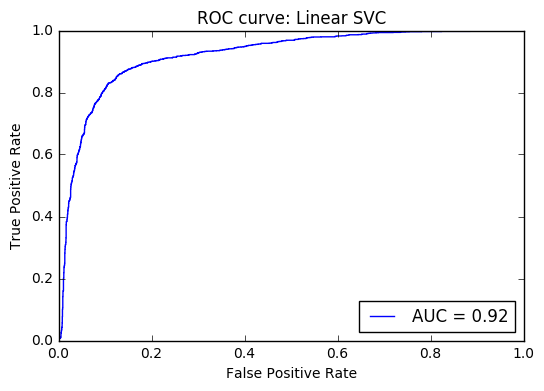

In [173]:
#ROC curve
#ROC curve (For selected k)
fpr, tpr, thresholds = roc_curve(target, pred_prob_svc[:, 1])
plt.plot(fpr, tpr, lw=1, label='AUC = %0.2f' % (auc_svc))
plt.xlim([0.0, 1.00])
plt.ylim([0.0, 1.00])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: Linear SVC')
plt.legend(loc="lower right")
plt.show()

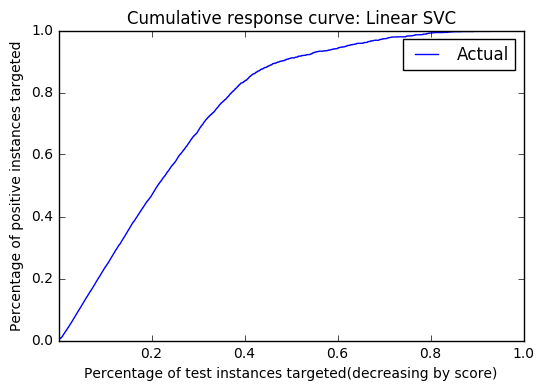

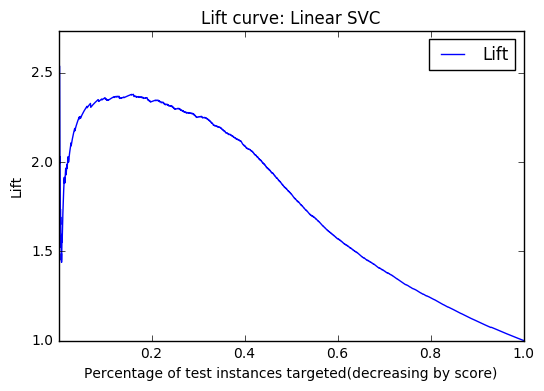

In [174]:
#CR curve and Lift curve
target_bc=pd.get_dummies(target).as_matrix()
ppd_pd=pd.DataFrame(pred_prob_svc[:,1],columns=['Predicted_prob'])
ppd_pd['Actual']=pd.Series(target_bc[:,1])
ppd_pd_sorted=ppd_pd.sort_values(['Predicted_prob'],ascending=0)
ppd_pd_sorted.index=range(1,len(ppd_pd_sorted.index)+1)

percent_targeted = pd.DataFrame(ppd_pd_sorted['Actual'].cumsum()/ppd_pd_sorted['Actual'].sum())
percent_targeted['Percent_test_instances']=range(1,len(ppd_pd_sorted.index)+1)
percent_targeted['Percent_test_instances']=percent_targeted['Percent_test_instances']/len(ppd_pd_sorted.index)
percent_targeted.index=range(1,len(ppd_pd_sorted.index)+1)
percent_targeted.plot(x='Percent_test_instances',y='Actual')
plt.xlabel('Percentage of test instances targeted(decreasing by score)')
plt.ylabel('Percentage of positive instances targeted')
plt.title('Cumulative response curve: Linear SVC')

percent_targeted['Actual_targetted']=ppd_pd_sorted['Actual']
percent_targeted['Lift']=percent_targeted['Actual_targetted'].cumsum()/(percent_targeted['Actual_targetted'].sum()*percent_targeted.index*1.0000/4601)
percent_targeted.plot(x='Percent_test_instances',y='Lift',ylim=[1,percent_targeted['Lift'].max()+0.2])
plt.xlabel('Percentage of test instances targeted(decreasing by score)')
plt.ylabel('Lift')
plt.title('Lift curve: Linear SVC')

In [177]:
nb = GaussianNB()
predicted_nb = cross_val_predict (nb, predictors_new, target, cv=10)
    
pred_prob_nb= cross_val_predict (nb, predictors_new, target, cv=10, method='predict_proba')
cm_nb=confusion_matrix(target,predicted_nb)
profit_matrix_nb = np.multiply(cm_nb, cost_matrix)
miscal_cost_nb = profit_matrix_nb.item(1) + profit_matrix_nb.item(2)
precision_nb = metrics.precision_score(target,predicted_nb)
recall_nb = metrics.recall_score(target,predicted_nb)
f_nb= metrics.f1_score(target,predicted_nb)
auc_nb= metrics.roc_auc_score(target,pred_prob_nb[:,1])
    
print 'Accuracy: {:.2f}%' .format(metrics.accuracy_score(target, predicted_nb)*100)
print 'Precision: {:.2f}%'.format(precision_nb*100)
print 'Recall: {:.2f}%'.format(recall_nb*100)
print 'F measure: {:.2f}'.format(f_nb)
print 'AUC: {:.2f}'.format(auc_nb)
print 'Misclassification cost: ${}' .format(miscal_cost_nb) 
print 'The confusion matrix is \n{}'.format(cm_nb)

Accuracy: 89.83%
Precision: 88.45%
Recall: 85.33%
F measure: 0.87
AUC: 0.95
Misclassification cost: $2286
The confusion matrix is 
[[2586  202]
 [ 266 1547]]


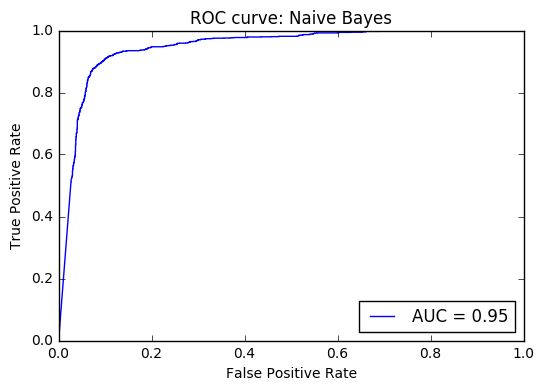

In [72]:
#ROC curve
fpr, tpr, thresholds = roc_curve(target, pred_prob_nb[:, 1])
plt.plot(fpr, tpr, lw=1, label='AUC = %0.2f' % (auc_nb))
plt.xlim([0.0, 1.00])
plt.ylim([0.0, 1.00])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: Naive Bayes')
plt.legend(loc="lower right")
plt.show()

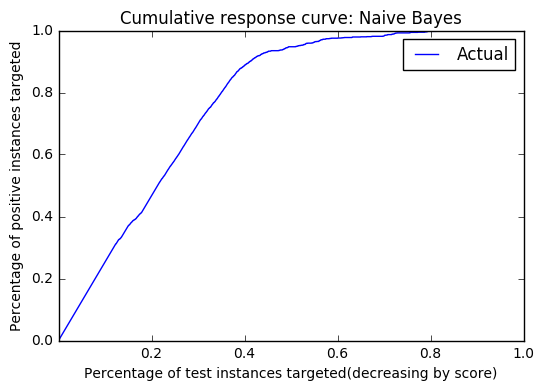

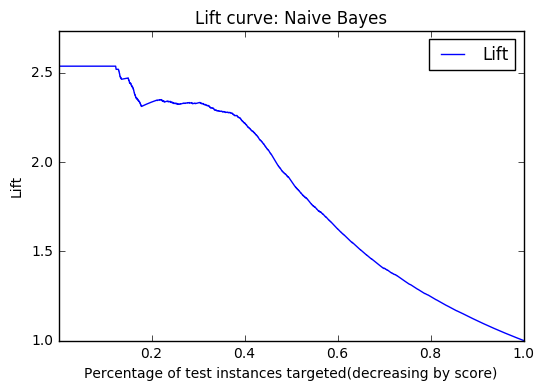

In [73]:
#CR curve and Lift curve
target_bc=pd.get_dummies(target).as_matrix()
ppd_pd=pd.DataFrame(pred_prob_nb[:,1],columns=['Predicted_prob'])
ppd_pd['Actual']=pd.Series(target_bc[:,1])
ppd_pd_sorted=ppd_pd.sort_values(['Predicted_prob'],ascending=0)
ppd_pd_sorted.index=range(1,len(ppd_pd_sorted.index)+1)

percent_targeted = pd.DataFrame(ppd_pd_sorted['Actual'].cumsum()/ppd_pd_sorted['Actual'].sum())
percent_targeted['Percent_test_instances']=range(1,len(ppd_pd_sorted.index)+1)
percent_targeted['Percent_test_instances']=percent_targeted['Percent_test_instances']/len(ppd_pd_sorted.index)
percent_targeted.index=range(1,len(ppd_pd_sorted.index)+1)
percent_targeted.plot(x='Percent_test_instances',y='Actual')
plt.xlabel('Percentage of test instances targeted(decreasing by score)')
plt.ylabel('Percentage of positive instances targeted')
plt.title('Cumulative response curve: Naive Bayes')

percent_targeted['Actual_targetted']=ppd_pd_sorted['Actual']
percent_targeted['Lift']=percent_targeted['Actual_targetted'].cumsum()/(percent_targeted['Actual_targetted'].sum()*percent_targeted.index/4601)
percent_targeted.plot(x='Percent_test_instances',y='Lift',ylim=[1,percent_targeted['Lift'].max()+0.2])
plt.xlabel('Percentage of test instances targeted(decreasing by score)')
plt.ylabel('Lift')
plt.title('Lift curve: Naive Bayes')